In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
# Suppress warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    import shap

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score, mean_absolute_percentage_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler

plt.rcParams['font.family'] ='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] =False

In [55]:
# Read the CSV
df = pd.read_csv('C:/Users/User/Downloads/Kyushu Datasheets/data_with_press_and_weather.csv', low_memory=False)

# Drop rows with excessive missing values
missing_count = df.isnull().sum().sum()
if missing_count > 0:
    threshold = df.shape[1] // 2
    df = df.dropna(thresh=threshold + 1)
    print(f"Rows with more than half NaN dropped. Remaining rows: {len(df)}")
else:
    print("No missing values found.")

Rows with more than half NaN dropped. Remaining rows: 2811


In [56]:
# Clean and filter '강번'
df['강번'] = pd.to_numeric(df['강번'], errors='coerce')
df = df.dropna(subset=['강번'])
df = df[df['강번'].between(9000, 500000000)]
df = df[df['수율'].between(60, 100)]

df.to_csv('For_my_use_1.csv', index=False)

# Make sure the date column is in datetime format
df['날짜'] = pd.to_datetime(df['날짜'], errors='coerce')

In [57]:
# Target variable
target = 'CC_P'

'''
# Outlier removal
if 'Precipitation (mm)' in df.columns:
    initial_count_oxygen = len(df)
    df = df[df['Precipitation (mm)'] <= 10]
    removed_count_oxygen = initial_count_oxygen - len(df)
    print(f"Removed {removed_count_oxygen} rows where {'Precipitation (mm)'} > 10.")
else:
    print(f"Warning: '{'Precipitation (mm)'}' column not found.")
'''
# chin_variables = [col for col in df.columns if '친' in col and '친단' not in col]
# df['chin_total'] = df[chin_variables].sum(axis=1)

scraps_col = [
    '스크랩_S01_친',
    '스크랩_S01_자',
    # '스크랩_S01_손', # for GPR
    'A부스러기　친',
    'A부스러기 자',
    'A부스러기 손',
    # '친단　친', # for GPR
    '친단　자',
    '친단　손',
    '와셔 친',
    # '와셔 자', # for GPR
    # '와셔 손', # for GPR
    'B부스러기　친',
    'B부스러기 자',
    'B부스러기 손',
    '선다라이 친',
    # '선다라이 자', # for GPR
    # '선다라이 손', # for GPR
    # '류선 친', # for GPR
    '류선 자',
    # '류선 손', # for GPR
    '시타마와리(자동차 부품으로 예상됨)　친',
    # '시타마와리(자동차 부품으로 예상됨)　자', # for GPR
    # '시타마와리(자동차 부품으로 예상됨)　손', # for GPR
    '엔진 친',
    # '엔진 자',
    # '엔진 손',
    '슈레더 친',
    '슈레더 자',
    '슈레더 손',
    'C프레스 친',
    'C프레스 자',
    # 'C프레스 손', # for GPR
    # '다라이가루 친', # for GPR
    '다라이가루 자',
    '다라이가루 손',
    '강류 친',
    # '강류 자', # for GPR
    # '강류 손', # for GPR
    '타이어 친',
    # '타이어　자', # for GPR
    # '타이어　손', # for GPR
    '주물　친',
    # '주물　자', # for GPR
    # '주물　손', # for GPR
    # '알루미더스트　친', # for GPR
    # '알루미더스트　자', # for GPR
    # '알루미더스트　손', # for GPR
    # 'AB프레스　친', # for GPR
    # 'AB프레스　자', # for GPR
    # 'AB프레스　손', # for GPR
    # 'Mn강　친', # for GPR
    # 'Mn강　자', # for GPR
    # 'Mn강　손', # for GPR
    # '캔버서　친', # for GPR
    # '캔버서　자', # for GPR
    # '캔버서　손', # for GPR
    # '페인트캔　친', # for GPR
    # '페인트캔　자', # for GPR
    # '페인트캔　손', # for GPR
    'V프레스　친',
    # 'V프레스　자', # for GPR
    # 'V프레스　손', # for GPR
    # '캔프레스　친', # for GPR
    '캔프레스　자',
    # '캔프레스　손', # for GPR
    '빌렛부스러기　친',
    # '빌렛부스러기 자', # for GPR
    # '빌렛부스러기 손', # for GPR
    # 'SC（레들）바탕쇠　친', # for GPR
    'SC（레들）바탕쇠　자',
    # 'SC（레들）바탕쇠　손', # for GPR
    # 'EF바탕쇠　친', # for GPR
    'EF바탕쇠　자',
    # 'EF바탕쇠　손', # for GPR
    # 'CC바탕쇠　친', # for GPR
    # 'CC바탕쇠　자', # for GPR
    # 'CC바탕쇠　손', # for GPR
    '정비부스러기　친',
    # '정비부스러기　자', # for GPR
    # '정비부스러기　손', # for GPR
]

chin_variables = [col for col in df.columns if '친' in col and '친단' not in col]
ja_variables = [col for col in df.columns if '자' in col]
son_variables = [col for col in df.columns if '손' in col]

scraps = chin_variables + ja_variables + son_variables

inputs = ['MD_C', 'MD_Mn', 'MD_Cr', 'MD_Si', 'MD_S']

#df[inputs] = df[inputs].div(df['장입량t'], axis=0)

extras = ['연회회수', 'Pressure_Local (hPa)', 'Pressure_SeaLevel (hPa)', 'Precipitation (mm)', 'Temperature (°C)', 'Relative Humidity (%)', 'WindSpeed_Avg (m/s)', 'WindSpeed_Max (m/s)']

# variables = []
X = df[scraps_col + inputs + extras +  ['장입량t'
                     #'TAP-TAP', '온도', 'CaO', '사용전력량', 'O2사용량_합계'
                     ]]
y = df[target]

# Sequential train-test split
split_index = int(len(X) * 0.7)
X_train = X.iloc[:split_index].fillna(0)
X_test = X.iloc[split_index:].fillna(0)
y_train = y.iloc[:split_index]
y_test = y.iloc[split_index:]

In [58]:
print(X_train.columns)

Index(['스크랩_S01_친', '스크랩_S01_자', 'A부스러기　친', 'A부스러기 자', 'A부스러기 손', '친단　자',
       '친단　손', '와셔 친', 'B부스러기　친', 'B부스러기 자', 'B부스러기 손', '선다라이 친', '류선 자',
       '시타마와리(자동차 부품으로 예상됨)　친', '엔진 친', '슈레더 친', '슈레더 자', '슈레더 손', 'C프레스 친',
       'C프레스 자', '다라이가루 자', '다라이가루 손', '강류 친', '타이어 친', '주물　친', 'V프레스　친',
       '캔프레스　자', '빌렛부스러기　친', 'SC（레들）바탕쇠　자', 'EF바탕쇠　자', '정비부스러기　친', 'MD_C',
       'MD_Mn', 'MD_Cr', 'MD_Si', 'MD_S', '연회회수', 'Pressure_Local (hPa)',
       'Pressure_SeaLevel (hPa)', 'Precipitation (mm)', 'Temperature (°C)',
       'Relative Humidity (%)', 'WindSpeed_Avg (m/s)', 'WindSpeed_Max (m/s)',
       '장입량t'],
      dtype='object')


In [59]:
def evaluate_model(name, model, X_train, y_train, X_test, y_test, df):
    print(f"\n--- {name} Model Evaluation ---")
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)
    # Ensure 1-D arrays
    train_pred = np.ravel(train_pred)
    test_pred = np.ravel(test_pred)

    # Convert y to 1-D numpy arrays (handles Series/DataFrame/ndarray)
    ytr = np.ravel(np.array(y_train))
    yte = np.ravel(np.array(y_test))

    # --- Metrics ---
    mse_train = mean_squared_error(ytr, train_pred)
    rmse_train = np.sqrt(mse_train)
    mae_train = mean_absolute_error(ytr, train_pred)
    # Safe MAPE
    denom_tr = np.where(ytr == 0, np.finfo(float).eps, ytr)
    mape_train = np.mean(np.abs((ytr - train_pred) / denom_tr)) * 100
    r2_train = r2_score(ytr, train_pred)

    mse_test = mean_squared_error(yte, test_pred)
    rmse_test = np.sqrt(mse_test)
    mae_test = mean_absolute_error(yte, test_pred)
    denom_te = np.where(yte == 0, np.finfo(float).eps, yte)
    mape_test = np.mean(np.abs((yte - test_pred) / denom_te)) * 100
    r2_test = r2_score(yte, test_pred)

    # --- Print ---
    print(f"{name} Train Scores:")
    print(f"  MSE:  {mse_train:.2f}")
    print(f"  RMSE: {rmse_train:.2f}")
    print(f"  MAE:  {mae_train:.2f}")
    print(f"  MAPE: {mape_train:.2f}%")
    print(f"  R²:   {r2_train:.3f}")

    print(f"\n{name} Test Scores:")
    print(f"  MSE:  {mse_test:.2f}")
    print(f"  RMSE: {rmse_test:.2f}")
    print(f"  MAE:  {mae_test:.2f}")
    print(f"  MAPE: {mape_test:.2f}%")
    print(f"  R²:   {r2_test:.3f}")

    # --- Plots ---
    # Assumes df has a '강번' column and X indices align with df
    train_df = df[['강번']].loc[X_train.index].copy()
    train_df['Actual'] = ytr
    train_df['Predicted'] = train_pred
    train_df['Set'] = 'Train'

    test_df = df[['강번']].loc[X_test.index].copy()
    test_df['Actual'] = yte
    test_df['Predicted'] = test_pred
    test_df['Set'] = 'Test'

    combined_df = pd.concat([train_df, test_df]).sort_values('강번').reset_index(drop=True)
    combined_df['Time Index'] = range(len(combined_df))

    plt.figure(figsize=(16, 4))
    plt.plot(combined_df['Time Index'], combined_df['Actual'], label='Actual', linewidth=2)
    plt.plot(combined_df['Time Index'], combined_df['Predicted'], label='Predicted', linestyle='--', linewidth=2)
    test_start = combined_df[combined_df['Set'] == 'Test']['Time Index'].min()
    if pd.notnull(test_start):
        plt.axvline(x=test_start, color='red', linestyle=':', label='Test Start')
    plt.xlabel('Time Index (chronological)')
    plt.ylabel(target)
    plt.title(f'Actual vs Predicted {target} ({name}) - R² = {r2_test:.3f}, RMSE = {rmse_test:.1f}')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Test-only plot
    test_df = test_df.sort_values('강번').reset_index(drop=True)
    test_df['Time Index'] = range(len(test_df))

    plt.figure(figsize=(18, 3))
    plt.plot(test_df['Time Index'], test_df['Actual'], label='Actual', linewidth=2)
    plt.plot(test_df['Time Index'], test_df['Predicted'], label='Predicted', linestyle='--', linewidth=2)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return test_df



--- Linear Regression Model Evaluation ---
Linear Regression Train Scores:
  MSE:  7.74
  RMSE: 2.78
  MAE:  2.13
  MAPE: 7.11%
  R²:   0.259

Linear Regression Test Scores:
  MSE:  6.41
  RMSE: 2.53
  MAE:  1.94
  MAPE: 6.57%
  R²:   -0.022


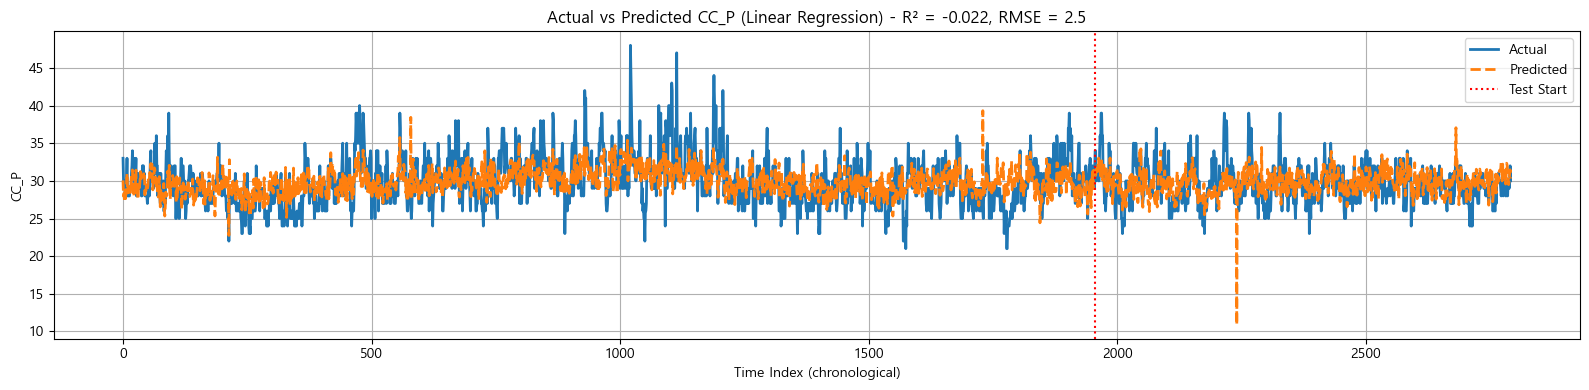

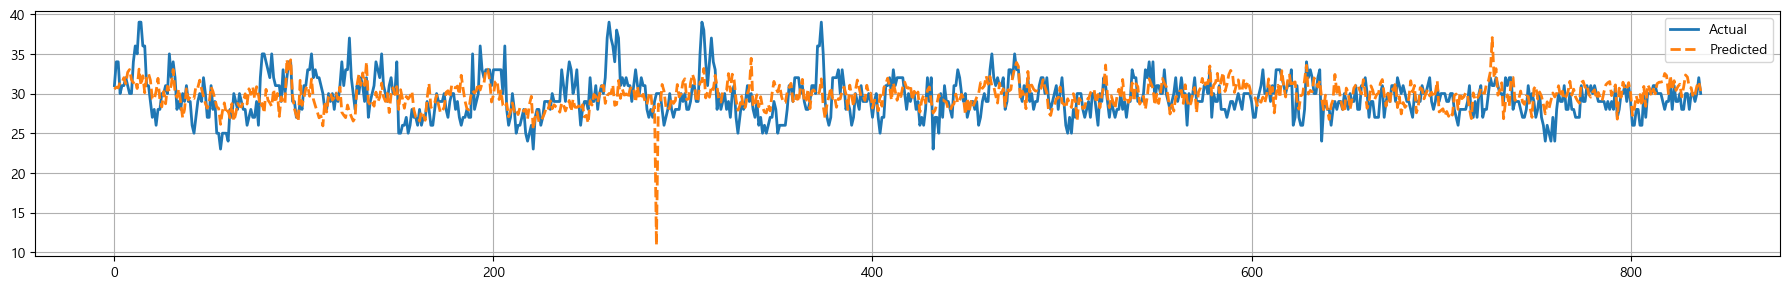

,강번,Actual,Predicted,Set,Time Index
0,2409202.0,31.0,30.559108,Test,0
1,2409203.0,34.0,30.807752,Test,1
2,2409204.0,34.0,30.710581,Test,2
3,2409205.0,30.0,31.428593,Test,3
4,2409206.0,31.0,31.379037,Test,4
...,...,...,...,...,...
833,2412241.0,30.0,29.505528,Test,833
834,2412242.0,29.0,29.901533,Test,834
835,2412243.0,30.0,30.949592,Test,835
836,2412244.0,32.0,31.472674,Test,836


In [60]:
# --- Linear Regression ---
lin_model = LinearRegression()
lin_model.fit(X_train, y_train)
evaluate_model("Linear Regression", lin_model, X_train, y_train, X_test, y_test, df)


--- XGBoost Model Evaluation ---
XGBoost Train Scores:
  MSE:  4.27
  RMSE: 2.07
  MAE:  1.59
  MAPE: 5.28%
  R²:   0.591

XGBoost Test Scores:
  MSE:  6.18
  RMSE: 2.49
  MAE:  1.99
  MAPE: 6.88%
  R²:   0.015


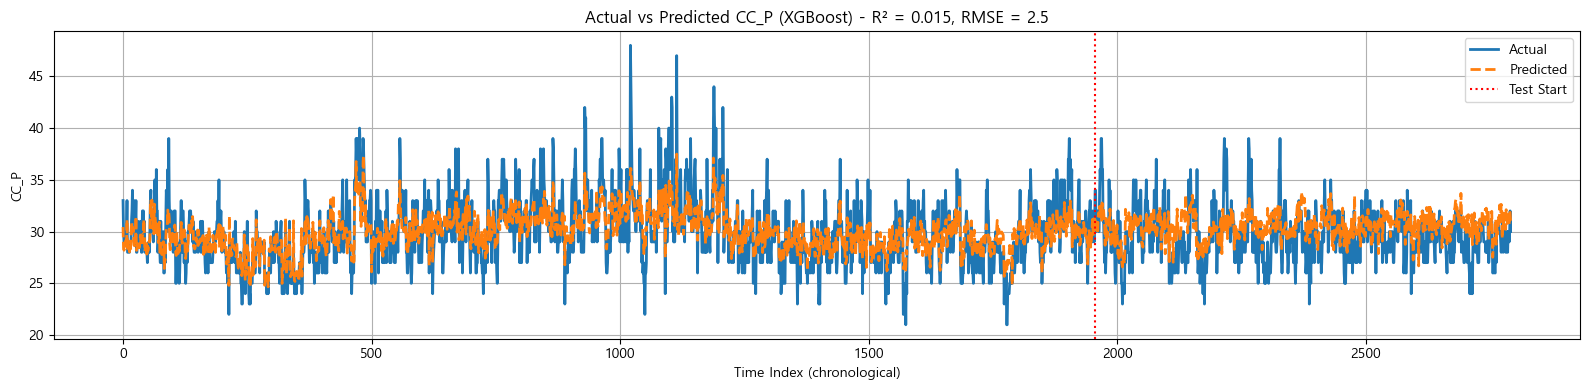

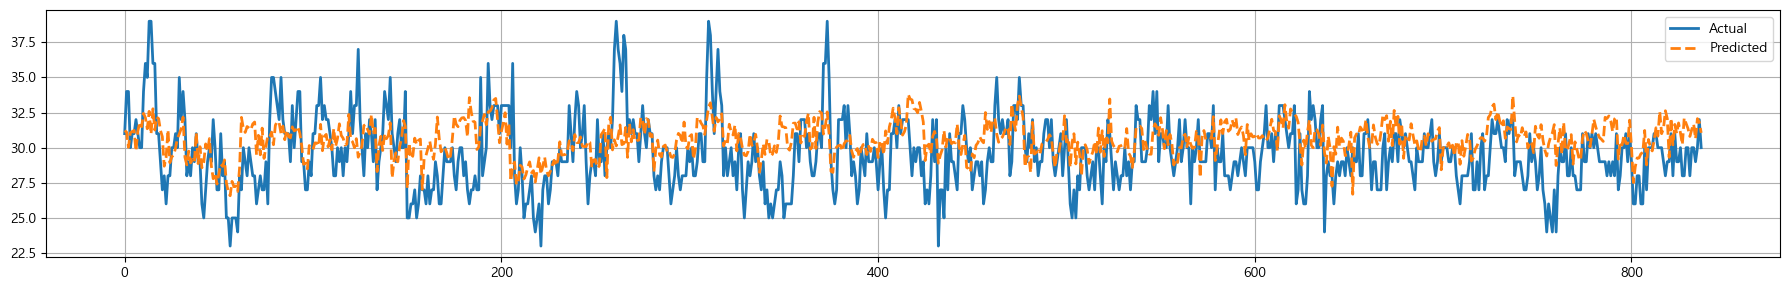

,강번,Actual,Predicted,Set,Time Index
0,2409202.0,31.0,31.216154,Test,0
1,2409203.0,34.0,31.116016,Test,1
2,2409204.0,34.0,30.027662,Test,2
3,2409205.0,30.0,31.057734,Test,3
4,2409206.0,31.0,31.151571,Test,4
...,...,...,...,...,...
833,2412241.0,30.0,31.687660,Test,833
834,2412242.0,29.0,30.634893,Test,834
835,2412243.0,30.0,32.065296,Test,835
836,2412244.0,32.0,31.824636,Test,836


In [61]:
# --- XGBoost ---
xgb_model = XGBRegressor(
    objective='reg:squarederror',
    n_estimators=1000,
    learning_rate=0.005,
    max_depth=4,
    random_state=42
)
xgb_model.fit(X_train, y_train)
evaluate_model("XGBoost", xgb_model, X_train, y_train, X_test, y_test, df)


--- Random Forest Model Evaluation ---
Random Forest Train Scores:
  MSE:  0.83
  RMSE: 0.91
  MAE:  0.68
  MAPE: 2.26%
  R²:   0.920

Random Forest Test Scores:
  MSE:  7.23
  RMSE: 2.69
  MAE:  2.18
  MAPE: 7.56%
  R²:   -0.153


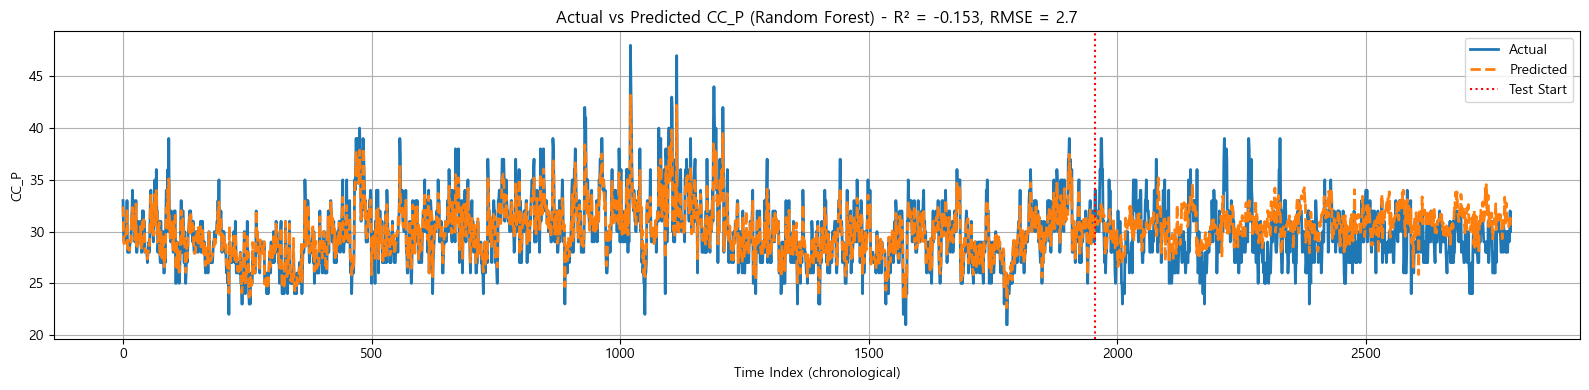

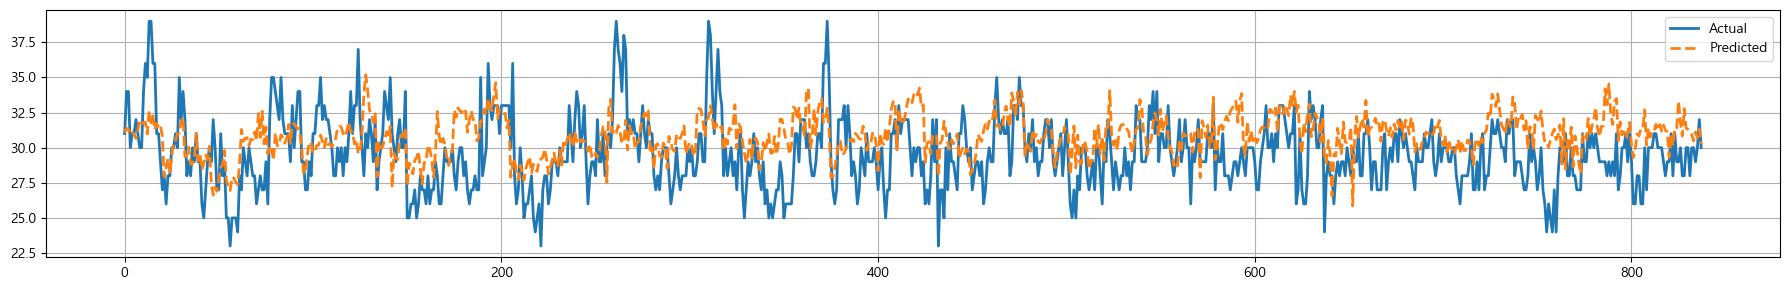

,강번,Actual,Predicted,Set,Time Index
0,2409202.0,31.0,31.07,Test,0
1,2409203.0,34.0,31.39,Test,1
2,2409204.0,34.0,31.30,Test,2
3,2409205.0,30.0,30.92,Test,3
4,2409206.0,31.0,31.07,Test,4
...,...,...,...,...,...
833,2412241.0,30.0,30.48,Test,833
834,2412242.0,29.0,31.11,Test,834
835,2412243.0,30.0,30.70,Test,835
836,2412244.0,32.0,31.32,Test,836


In [62]:
# --- Random Forest ---
rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X_train, y_train)
evaluate_model("Random Forest", rf_model, X_train, y_train, X_test, y_test, df)


--- SVR (RBF) Model Evaluation ---
SVR (RBF) Train Scores:
  MSE:  1.66
  RMSE: 1.29
  MAE:  0.65
  MAPE: 2.09%
  R²:   0.841

SVR (RBF) Test Scores:
  MSE:  7.04
  RMSE: 2.65
  MAE:  2.09
  MAPE: 7.16%
  R²:   -0.122


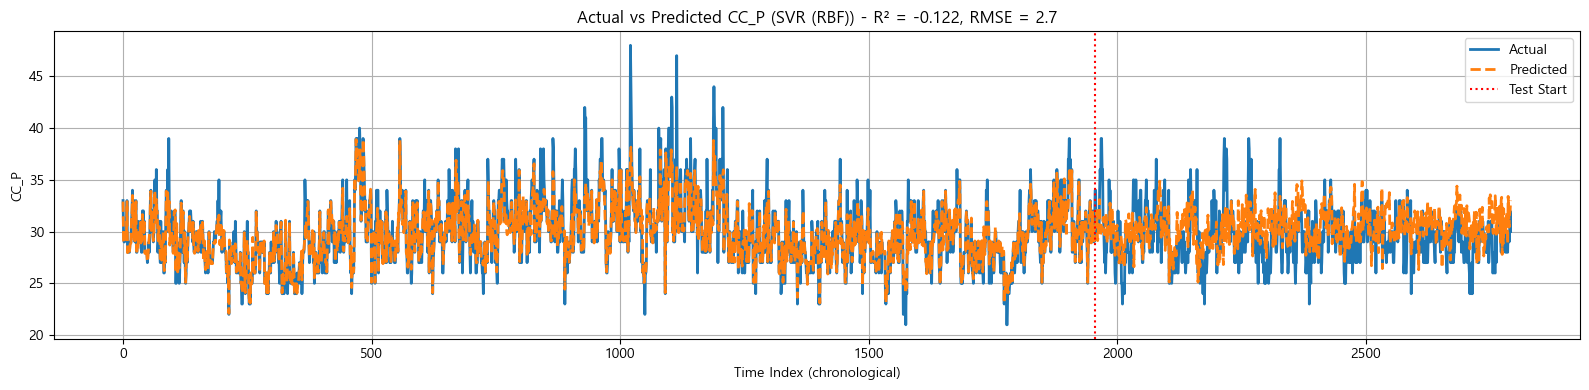

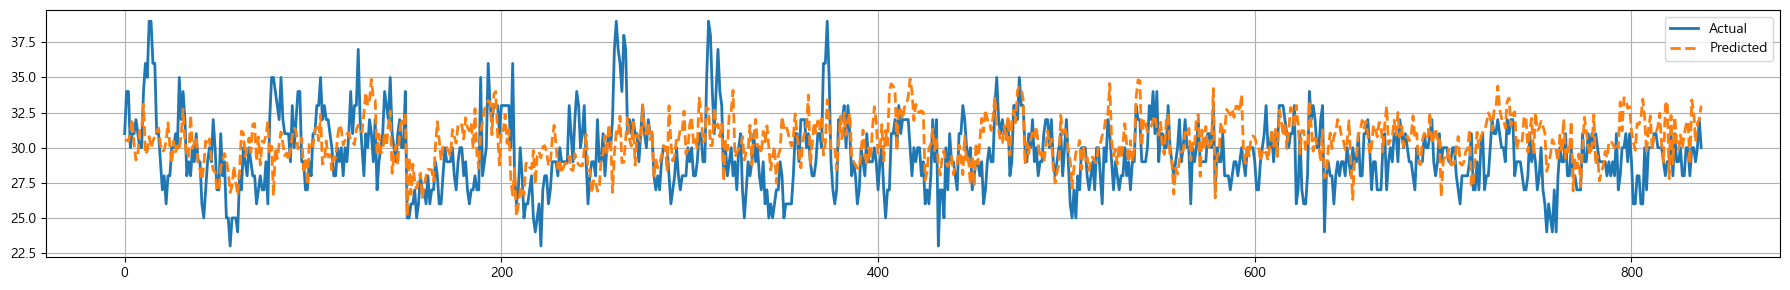

Iteration 1, loss = 185.37487119
Iteration 2, loss = 22.43485112
Iteration 3, loss = 14.18908026
Iteration 4, loss = 10.24821463
Iteration 5, loss = 8.07744000
Iteration 6, loss = 6.47262379
Iteration 7, loss = 5.49765177
Iteration 8, loss = 4.68515911
Iteration 9, loss = 4.19575102
Iteration 10, loss = 3.85089934
Iteration 11, loss = 3.53114375
Iteration 12, loss = 3.38449899
Iteration 13, loss = 3.10264758
Iteration 14, loss = 2.83315915
Iteration 15, loss = 2.82032474
Iteration 16, loss = 2.57741382
Iteration 17, loss = 2.42107415
Iteration 18, loss = 2.48605903
Iteration 19, loss = 2.12754695
Iteration 20, loss = 1.95289795
Iteration 21, loss = 1.86465600
Iteration 22, loss = 1.78467345
Iteration 23, loss = 1.76868789
Iteration 24, loss = 1.62467857
Iteration 25, loss = 1.79345047
Iteration 26, loss = 1.52371412
Iteration 27, loss = 1.48840877
Iteration 28, loss = 1.29590072
Iteration 29, loss = 1.20233977
Iteration 30, loss = 1.15214311
Iteration 31, loss = 1.16293350
Iteration 32

c:\Users\User\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:780: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


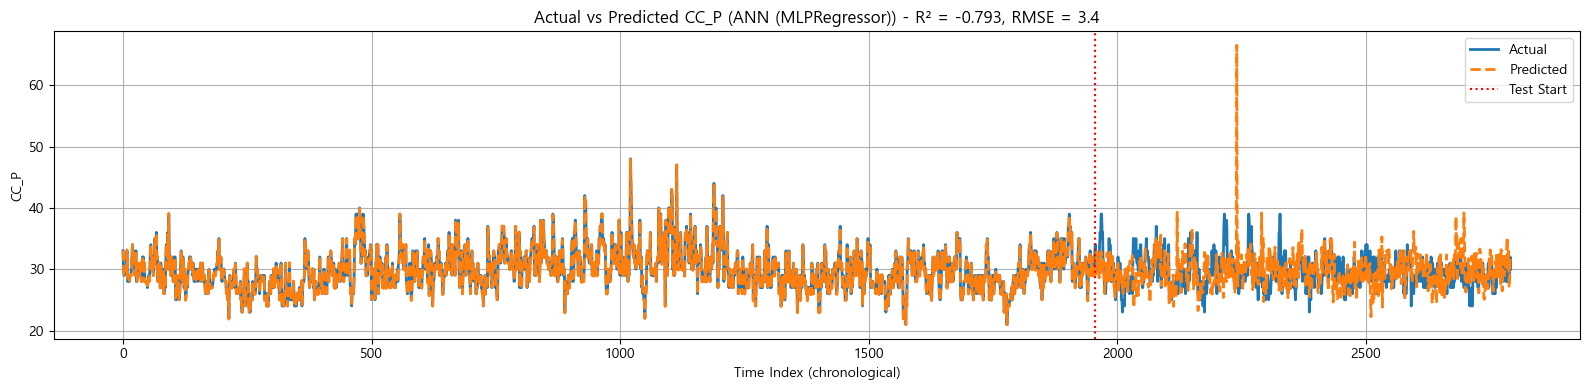

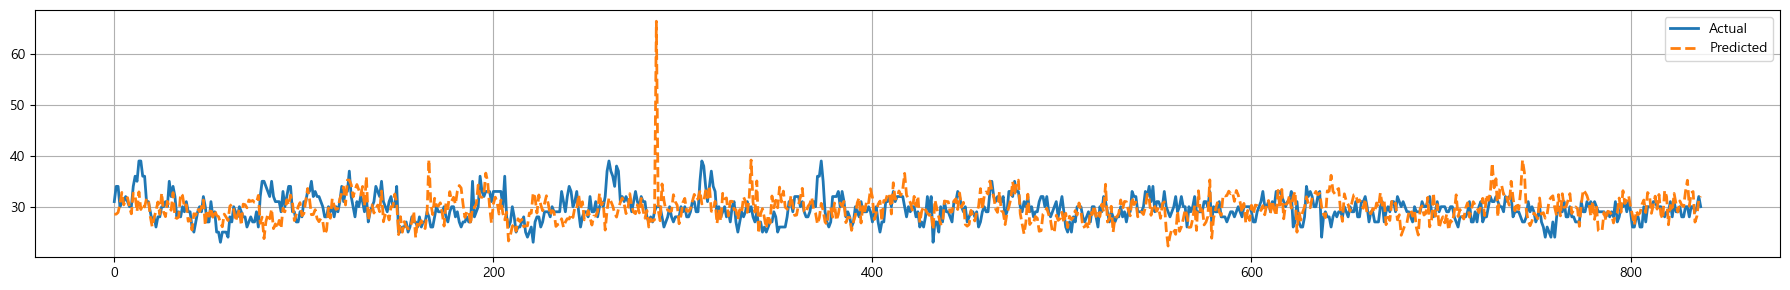

In [63]:

# === Added on 2025-08-08 04:07:56: SVM (SVR) and ANN (MLPRegressor) implementations ===
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor

# SVR pipeline (scale features)
svr_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svr', SVR(kernel='rbf', C=10.0, epsilon=0.1, gamma='scale'))
])

svr_pipeline.fit(X_train, y_train)
svr_test_df = evaluate_model("SVR (RBF)", svr_pipeline, X_train, y_train, X_test, y_test, df)


ann_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('mlp', MLPRegressor(
        hidden_layer_sizes=(128, 128, 128, 64),
        activation='relu',
        solver='adam',
        learning_rate='adaptive',
        batch_size=50,
        max_iter=2000,
        early_stopping=False,      # don't use validation-based early stop
        n_iter_no_change=2000,     # >> max_iter so it won't stop early
        tol=0.0,                   # require strict improvement (optional)
        random_state=42,
        verbose=True
    ))
])

ann_pipeline.fit(X_train, y_train)
ann_test_df = evaluate_model("ANN (MLPRegressor)", ann_pipeline, X_train, y_train, X_test, y_test, df)



 96%|=================== | 1879/1955 [00:20<00:00]       


--- SHAP Summary: XGBoost ---


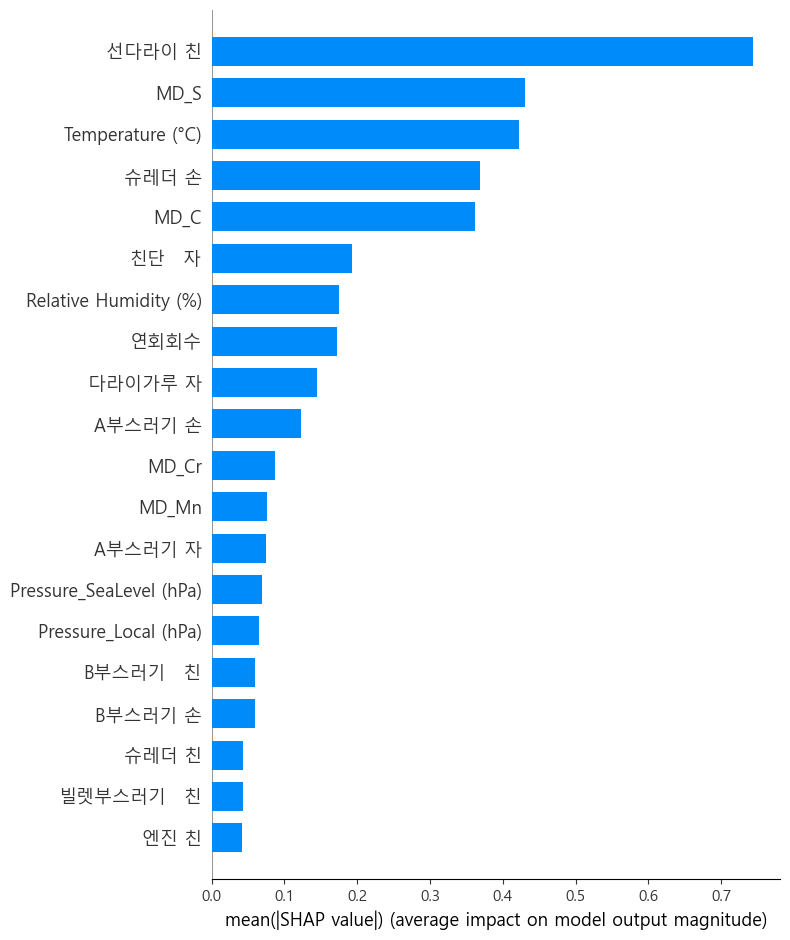

In [64]:
# SHAP for XGBoost (TreeExplainer is fast and accurate)
explainer_xgb = shap.Explainer(xgb_model, X_train)
shap_values_xgb = explainer_xgb(X_train)

# Global importance plot
print("\n--- SHAP Summary: XGBoost ---")
shap.summary_plot(shap_values_xgb, X_train, plot_type="bar")

 99%|===================| 1939/1955 [00:20<00:00]        


--- SHAP Summary: XGBoost ---


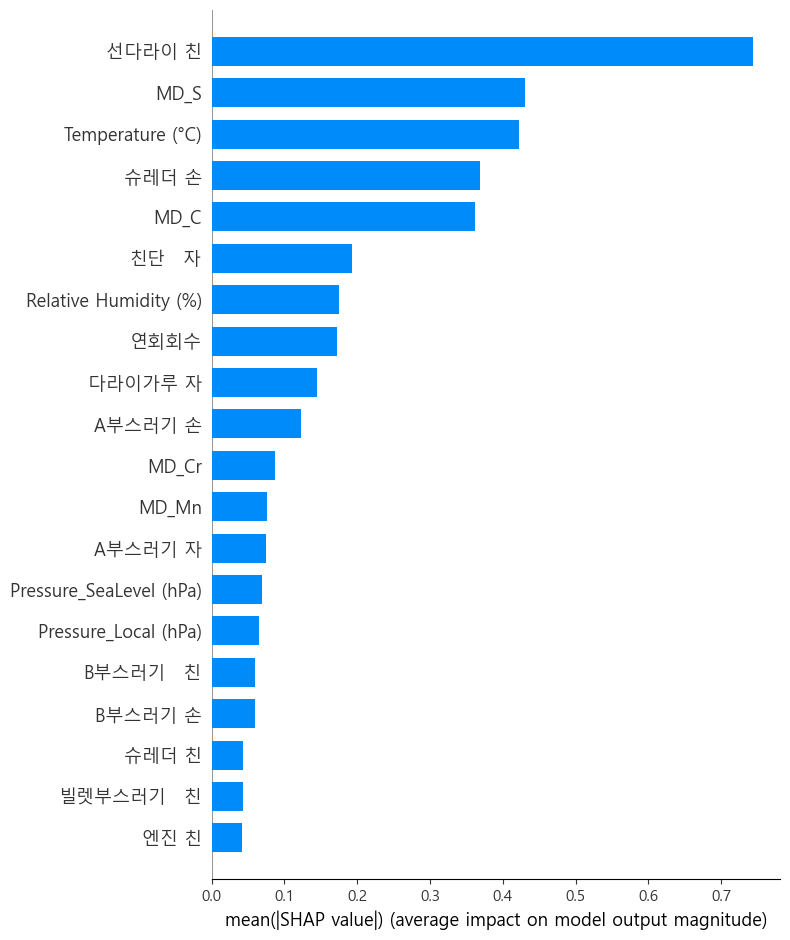

In [65]:
# SHAP for XGBoost (TreeExplainer is fast and accurate)
explainer_xgb = shap.Explainer(xgb_model, X_train)
shap_values_xgb = explainer_xgb(X_train)

# Global importance plot
print("\n--- SHAP Summary: XGBoost ---")
shap.summary_plot(shap_values_xgb, X_train, plot_type="bar")